In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import operator

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
df = pd.read_csv('../datasets/filingsEnd2020.csv')

In [3]:
# take a look
df.head()

,Unnamed: 0,filed name,cusip,value,amount,put_or_call,owner,cik,report_date
0,0,89BIO INC,282559103,1072.0,44007.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31
1,1,ACTINIUM PHARMACEUTICALS INC,00507W206,702.0,90000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31
2,2,ADAMAS PHARMACEUTICALS INC,00548A106,1909.0,440955.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31
3,3,AFFIMED N V,N01045108,2328.0,400000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31
4,4,AKERO THERAPEUTICS INC,00973Y108,908.0,35179.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31


In [4]:
# an issuer can have multiple different CUSIP's (first class shares, normal shares, etc)
# they are all money however so we will aggregate them in the future

df['issuer'] = df['cusip'].apply(lambda x: x[:6])
df.head()

,Unnamed: 0,filed name,cusip,value,amount,put_or_call,owner,cik,report_date,issuer
0,0,89BIO INC,282559103,1072.0,44007.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,282559
1,1,ACTINIUM PHARMACEUTICALS INC,00507W206,702.0,90000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00507W
2,2,ADAMAS PHARMACEUTICALS INC,00548A106,1909.0,440955.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00548A
3,3,AFFIMED N V,N01045108,2328.0,400000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,N01045
4,4,AKERO THERAPEUTICS INC,00973Y108,908.0,35179.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00973Y


In [5]:
# compute total value for each CIK, to normalize investments later

totalValue = df.groupby('owner')['value'].sum()

df = df.merge(totalValue, how='left', left_on='owner', right_index=True)
df.head()

,Unnamed: 0,filed name,cusip,value_x,amount,put_or_call,owner,cik,report_date,issuer,value_y
0,0,89BIO INC,282559103,1072.0,44007.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,282559,163799.0
1,1,ACTINIUM PHARMACEUTICALS INC,00507W206,702.0,90000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00507W,163799.0
2,2,ADAMAS PHARMACEUTICALS INC,00548A106,1909.0,440955.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00548A,163799.0
3,3,AFFIMED N V,N01045108,2328.0,400000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,N01045,163799.0
4,4,AKERO THERAPEUTICS INC,00973Y108,908.0,35179.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00973Y,163799.0


In [6]:
# drop some "useless" columns

df.drop(columns=['Unnamed: 0', 'cusip', 'amount', 'put_or_call', 'report_date'], inplace=True)
df.head()

,filed name,value_x,owner,cik,issuer,value_y
0,89BIO INC,1072.0,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,282559,163799.0
1,ACTINIUM PHARMACEUTICALS INC,702.0,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,00507W,163799.0
2,ADAMAS PHARMACEUTICALS INC,1909.0,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,00548A,163799.0
3,AFFIMED N V,2328.0,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,N01045,163799.0
4,AKERO THERAPEUTICS INC,908.0,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,00973Y,163799.0


In [7]:
# compute normalized value

df['norm_value'] = df['value_x'] / df['value_y']

In [8]:
# some have reported investments of value==0, drop them

mask = df['value_x'] == 0
df = df.loc[~mask]

In [9]:
# we're gonna need the issuer names for labeling

issuers = df.drop_duplicates(subset='issuer')
issuers['label'] = issuers['filed name'].apply(lambda x: ' '.join(x[:].split(' ')[:3]))
issuers = issuers[['label', 'issuer']]
#issuers

<ipython-input-9-d5e49a45e54f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issuers['label'] = issuers['filed name'].apply(lambda x: ' '.join(x[:].split(' ')[:3]))


In [10]:
# perform final aggregation and inspect

df = df.groupby(['cik','issuer']).agg({'norm_value': 'sum'})
df = df.reset_index()
df

,cik,issuer,norm_value
0,5272,000360,0.000068
1,5272,000361,0.000030
2,5272,00081T,0.000017
3,5272,000868,0.000005
4,5272,000899,0.000003
...,...,...,...
160448,1849834,25809K,0.934931
160449,1849834,31188V,0.014215
160450,1849834,31816Q,0.025669
160451,1849834,68376D,0.012929


In [11]:
# we need to turn the DF into wide form, use it like feature vectors

wideDf = df.pivot(index='cik', columns='issuer', values='norm_value').fillna(value=0)
wideDf

issuer,00000I,00000K,00000L,00000N,000360,000361,000375,000380,00080Q,00081T,...,m7516k,n44821,n53745,n6596x,n71542,n72482,y09827,y2106r,y2573f,y8564m
cik,,,,,,,,,,,,,,,,,,,,,
5272,0.0,0.0,0.0,0.0,0.000068,0.00003,0.000000,0.000000e+00,0.0,0.000017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19617,0.0,0.0,0.0,0.0,0.000008,0.00004,0.000002,1.462913e-07,0.0,0.000033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20286,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48966,0.0,0.0,0.0,0.0,0.000000,0.00000,0.006491,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52234,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846462,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1846639,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1846789,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


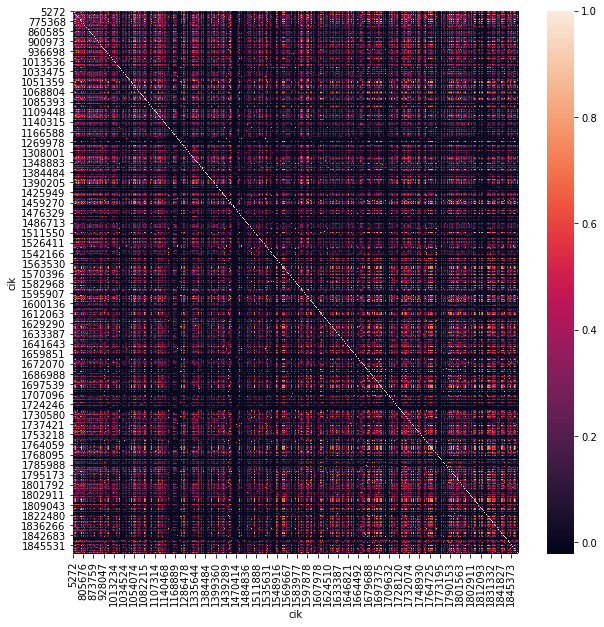

In [12]:
# compute correlation between investors

correlation = wideDf.transpose().corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation);

/home/jradhima/miniconda3/envs/mda/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


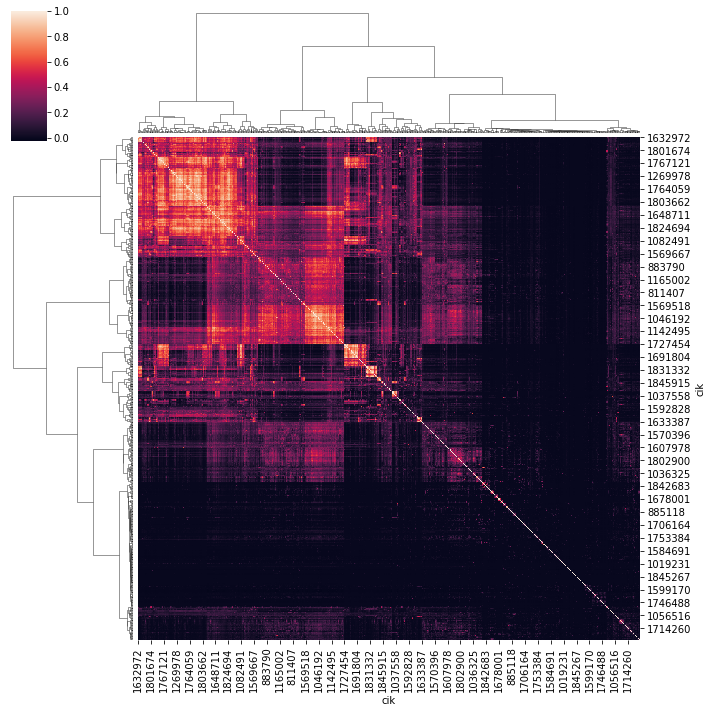

In [13]:
# pick a method out of 'single', 'complete', 'centroid', 'ward'

method = 'ward'

# cluster the correlation matrix to show connectivity

clmap = sns.clustermap(correlation, method=method)

In [14]:
# this calculates something like an ROC curve, but for investor correlation 
# we binarize the correlation values into 0/1 based on a threshold
# then calculate the sum of connections and divide by the total possible connections

thresh = np.arange(0.05,1.01,0.05)
connectPer100 = {}

for val in thresh:
    cor1 = correlation.copy()
    
    cor1[cor1 >= val] = 1
    cor1[cor1 < val] = 0
    
    connectPer100[round(val,3)] = round(cor1.sum().sum() / cor1.shape[0]**2 * 100,3)

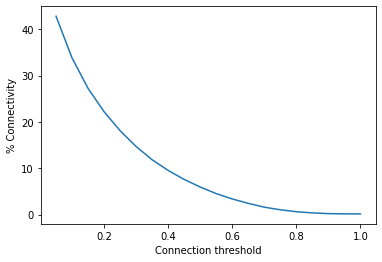

In [15]:
# an example

plt.plot(connectPer100.keys(), connectPer100.values());
plt.xlabel('Connection threshold');
plt.ylabel('% Connectivity');

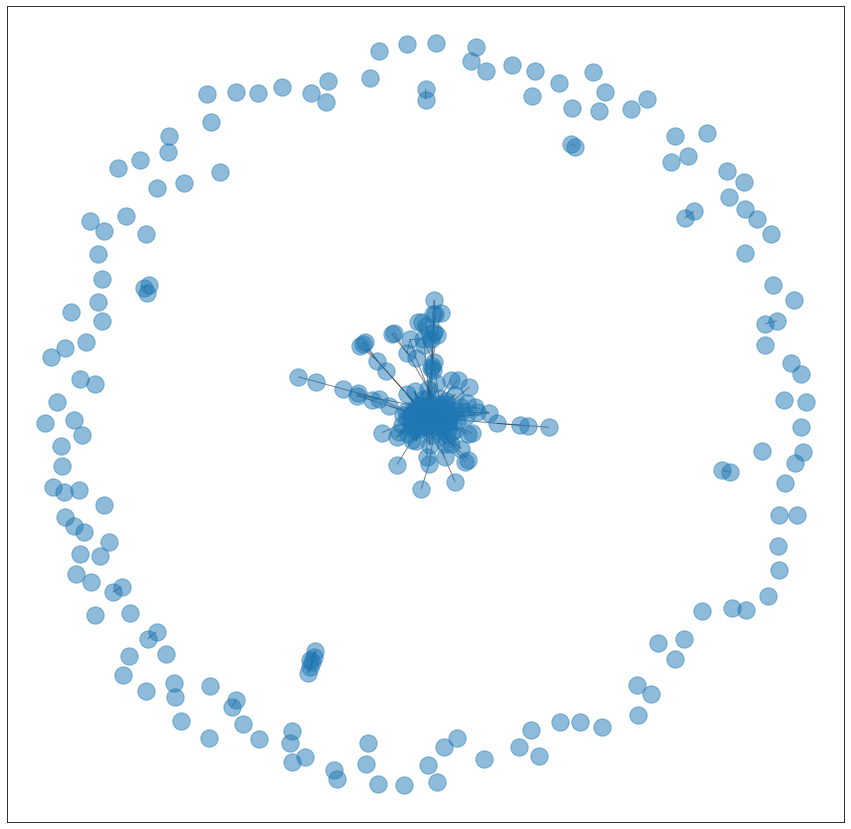

In [16]:
# pick a threshold value

threshold = 0.3

# create graph with threshold

cor1 = correlation.copy()
    
cor1[cor1 >= threshold] = 1
cor1[cor1 < threshold] = 0

gr = nx.convert_matrix.from_pandas_adjacency(cor1)

# draw the graph

pos = nx.spring_layout(gr)

plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(gr, pos, alpha=0.5)
nx.draw_networkx_edges(gr, pos, alpha=0.5)

In [17]:
# let's try a more complete example


# pick a threshold below which no edge is added on the graph
# for example, threshold = 0.025

threshold = 0.05

# now pick an 'gravity' factor
# factors above 1 lead to a more clustered graph
# factors below 1 lead to a more spread-out graph
# values between 0.5-1 make best graphs
# lower threshold values need lower gravity factors

gravity = 0.4

investors = []
companies = []

G=nx.Graph()
for i in df.index:
    edge = df.iloc[i,]
    if edge['norm_value'] > threshold:
        G.add_edge(edge['cik'], edge['issuer'], weight=edge['norm_value'] ** (1/gravity))
        investors.append(edge['cik'])
        companies.append(edge['issuer'])

In [18]:
# calculate centrality
degCent = nx.degree_centrality(G)

# get positions
pos = nx.spring_layout(G)  # positions for all nodes

In [19]:
print(f"Nodes in graph: {len(G.nodes())}\nEdges in graph: {len(G.edges())}")

Nodes in graph: 1457
Edges in graph: 2393


In [20]:
# calculate node size based on centrality for each group

investorSize = [degCent[investor]**1.5 * 10000 for investor in investors]
issuerSize = [degCent[issuer]**1.5 * 10000 for issuer in companies]

# calculate edge size
edgeSize = [d['weight'] ** (gravity) for (u, v, d) in G.edges(data=True)]

In [21]:
#pick how many labels you want displayed

num = 20

# get num most central issuers
sorted_x = sorted(degCent.items(), key=operator.itemgetter(1), reverse=True)
central = [item[0] for item in sorted_x[:num] if type(item[0]) == str]

# turn list into dictionary
labels = {}
for code in central:
    try:
        labels[code] = issuers[issuers['issuer'] == code]['label'].item()
    except:
        labels[code] = code

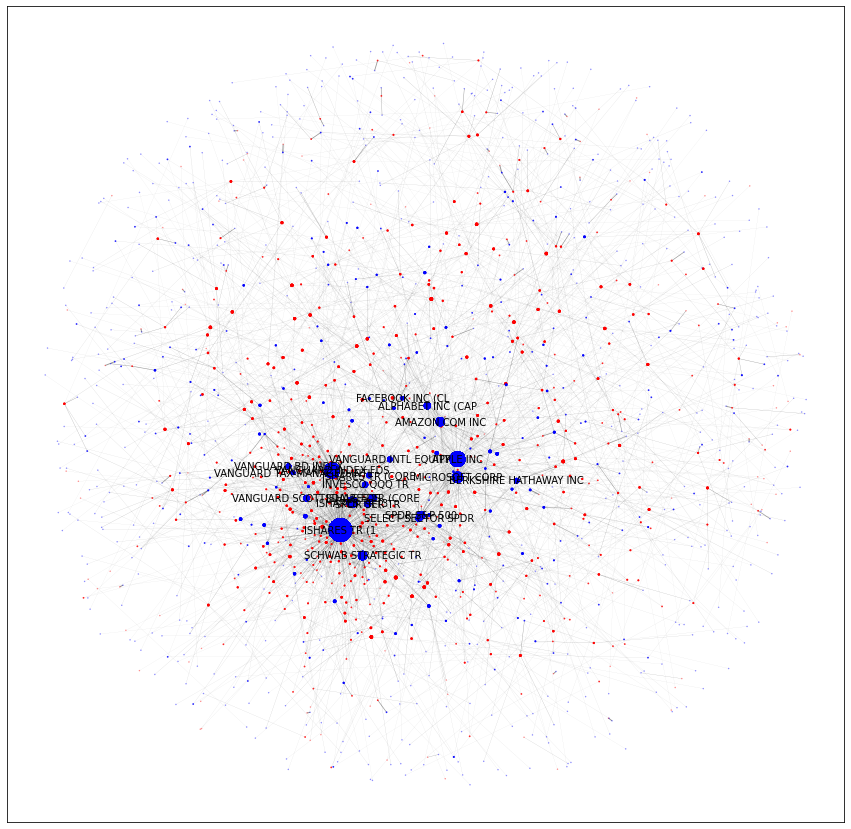

In [23]:
# let's draw
plt.figure(figsize=(15,15))

# draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=investors, node_size=investorSize, alpha=0.5, node_color='r')

# draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=companies, node_size=issuerSize, alpha=0.5, node_color='b')

# edges
nx.draw_networkx_edges(
    G, pos, width=edgeSize, alpha=0.4, edge_color="k")

# labels
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_family="sans-serif", font_color='k');